## Parameter estimation with discovery and numpyro

Creating MCMC chains with discovery likelihoods and `numpyro`'s [NUTS sampler](https://num.pyro.ai/en/latest/mcmc.html).

Obviously, `discovery.samplers.numpyro` requires `numpyro`.

In [2]:
import sys
import os
import glob

import tqdm

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pp

%matplotlib inline

In [4]:
import jax
jax.config.update('jax_enable_x64', True)

import jax.random
import jax.numpy as jnp

In [6]:
import discovery as ds
import discovery.models.nanograv as ds_nanograv
import discovery.samplers.numpyro as ds_numpyro

Read nanograv pulsars

In [8]:
allpsrs = [ds.Pulsar.read_feather(psrfile) for psrfile in sorted(glob.glob('../data/*-[JB]*.feather'))]

Run with fewer pulsars to converge on GPU

In [10]:
allpsrs = allpsrs[:5]

Set up a NANOGrav CURN model. Possible options to `makemodel_curn` are `rn_components`, `crn_components`, and `gamma=<fixed_value>`. For an HD model, use `ds_nanograv.makemodel_hd`.

In [12]:
model = ds_nanograv.makemodel_curn(allpsrs)

Obtain the likelihood

In [16]:
logl = model.logL

These are the parameters.

In [17]:
logl.params

['B1855+09_red_noise_gamma',
 'B1855+09_red_noise_log10_A',
 'B1937+21_red_noise_gamma',
 'B1937+21_red_noise_log10_A',
 'B1953+29_red_noise_gamma',
 'B1953+29_red_noise_log10_A',
 'J0023+0923_red_noise_gamma',
 'J0023+0923_red_noise_log10_A',
 'J0030+0451_red_noise_gamma',
 'J0030+0451_red_noise_log10_A',
 'crn_gamma',
 'crn_log10_A']

Sample parameter values from their default uniform priors.

In [18]:
p0 = ds.sample_uniform(logl.params)

Try likelihood, compiled version, likelihood gradient.

In [20]:
logl(p0)

Array(914691.13889637, dtype=float64)

In [21]:
jax.jit(logl)(p0)

Array(914691.13889637, dtype=float64)

In [22]:
jax.grad(logl)(p0)

{'B1855+09_red_noise_gamma': Array(-0.0009749, dtype=float64, weak_type=True),
 'B1855+09_red_noise_log10_A': Array(-0.00166683, dtype=float64, weak_type=True),
 'B1937+21_red_noise_gamma': Array(-0.0004357, dtype=float64, weak_type=True),
 'B1937+21_red_noise_log10_A': Array(-0.00086616, dtype=float64, weak_type=True),
 'B1953+29_red_noise_gamma': Array(-0.01444272, dtype=float64, weak_type=True),
 'B1953+29_red_noise_log10_A': Array(-0.02485109, dtype=float64, weak_type=True),
 'J0023+0923_red_noise_gamma': Array(-4.61835094e-11, dtype=float64, weak_type=True),
 'J0023+0923_red_noise_log10_A': Array(-9.62121944e-11, dtype=float64, weak_type=True),
 'J0030+0451_red_noise_gamma': Array(-0.00069229, dtype=float64, weak_type=True),
 'J0030+0451_red_noise_log10_A': Array(-0.00137895, dtype=float64, weak_type=True),
 'crn_gamma': Array(-25.50380024, dtype=float64, weak_type=True),
 'crn_log10_A': Array(-504.46209096, dtype=float64, weak_type=True)}

Make a numpyro model, transforming likelihood to standard `[-inf, inf]` parameter ranges.

In [23]:
npmodel = ds_numpyro.makemodel_transformed(logl)

Make a numpyro NUTS sampler object. Numypro arguments for `infer.MCMC` and `infer.NUTS` are supported.

In [27]:
npsampler = ds_numpyro.makesampler_nuts(npmodel)

Run with a set random seed.

In [28]:
npsampler.run(jax.random.PRNGKey(42))

sample: 100%|███████████████████████████████████████████████████████████████████████████| 1536/1536 [00:53<00:00, 28.91it/s, 31 steps of size 1.37e-01. acc. prob=0.85]


`discovery` enhances the `numpyro` sampler with a method `to_df()` that returns the sampler chain as a pandas `DataFrame`.

In [29]:
chain = npsampler.to_df()

In [31]:
chain

,B1855+09_red_noise_gamma,B1855+09_red_noise_log10_A,B1937+21_red_noise_gamma,B1937+21_red_noise_log10_A,B1953+29_red_noise_gamma,B1953+29_red_noise_log10_A,J0023+0923_red_noise_gamma,J0023+0923_red_noise_log10_A,J0030+0451_red_noise_gamma,J0030+0451_red_noise_log10_A,crn_gamma,crn_log10_A
0,6.476984,-18.148467,4.089248,-13.520661,1.075246,-12.642510,5.500433,-18.054510,0.494193,-15.080699,4.255313,-14.181534
1,0.013168,-16.318226,3.942949,-13.649348,4.265511,-13.434208,1.890570,-13.717133,5.991677,-18.095588,3.959131,-14.168350
2,0.008013,-17.412356,4.291904,-13.584551,4.502505,-13.422527,2.607725,-16.042287,5.190236,-17.986991,3.985542,-14.211795
3,2.891030,-17.814518,4.211965,-13.615802,0.395461,-12.660168,4.132601,-19.332417,0.611211,-17.589698,3.217800,-13.794063
4,2.965423,-15.693120,3.741948,-13.572435,0.256944,-12.584014,0.387995,-19.913435,6.216158,-17.504121,3.778628,-13.996851
...,...,...,...,...,...,...,...,...,...,...,...,...
1019,2.442326,-18.021231,4.636352,-13.734986,2.430792,-13.031007,4.129197,-16.518822,2.839567,-19.432986,3.057165,-13.757071
1020,2.880649,-18.471594,4.405029,-13.796660,2.809793,-13.066353,4.538688,-16.337045,1.827672,-19.730748,3.071215,-13.836040
1021,5.352179,-19.604518,4.404296,-13.660947,2.805014,-13.006893,3.836079,-16.749440,1.109886,-18.662330,3.386114,-13.757132
1022,3.455395,-16.677092,3.856385,-13.595281,2.120671,-12.838609,1.916079,-14.054348,2.648604,-18.986566,3.253295,-13.718977


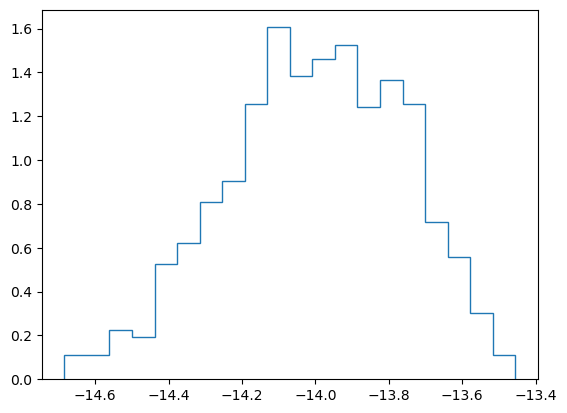

In [34]:
pp.hist(chain['crn_log10_A'], bins=20, histtype='step', density=True);